In [3]:
from math import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2, EstimatorV2, QiskitRuntimeService
from qiskit.visualization import plot_histogram

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# from qiskit.quantum_info import SparsePauliOp
# from qiskit_aer import AerSimulator

obsv_list = [
    [SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'], [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j])],
    [SparsePauliOp(['XXYY'], [-0.04530262+0.j])],
    [SparsePauliOp(['XYYX'], [ 0.04530262+0.j])],
    [SparsePauliOp(['YXXY'], [ 0.04530262+0.j])],
    [SparsePauliOp(['YYXX'], [-0.04530262+0.j])]
]

angles = [pi/2]

### Estimator

        ┌───┐   ┌───┐                                                     ┌───┐
q_3: ───┤ X ├───┤ H ├──■───────────────────────────────────────────■──────┤ H ├
        ├───┤   ├───┤┌─┴─┐                                       ┌─┴─┐    ├───┤
q_2: ───┤ X ├───┤ H ├┤ X ├──■──────────────────────────────■─────┤ X ├────┤ H ├
     ┌──┴───┴──┐└───┘└───┘┌─┴─┐                          ┌─┴─┐┌──┴───┴───┐└───┘
q_1: ┤ Rx(π/2) ├──────────┤ X ├──■────────────────────■──┤ X ├┤ Rx(-π/2) ├─────
     └──┬───┬──┘          └───┘┌─┴─┐┌──────────────┐┌─┴─┐├───┤└──────────┘     
q_0: ───┤ H ├──────────────────┤ X ├┤ Rz(-2*theta) ├┤ X ├┤ H ├─────────────────
        └───┘                  └───┘└──────────────┘└───┘└───┘                 


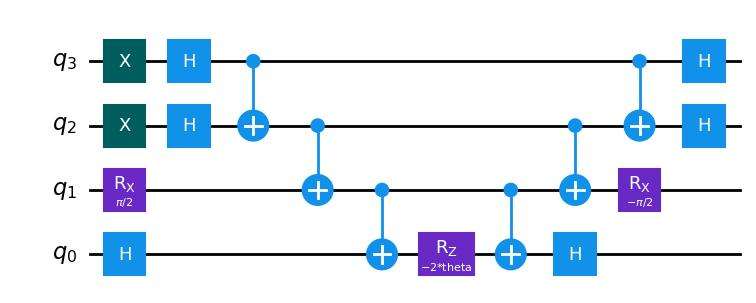

In [5]:
estimator = EstimatorV2(backend=AerSimulator())

theta = Parameter('theta')

ansatz = QuantumCircuit(4)
ansatz.x([2,3])
ansatz.h(0)
ansatz.rx(pi/2,1)
ansatz.h([2,3])

ansatz.cx(3,2)
ansatz.cx(2,1)
ansatz.cx(1,0)
ansatz.rz(-2*theta,0)

ansatz.cx(1,0)
ansatz.cx(2,1)
ansatz.cx(3,2)
ansatz.h(0)
ansatz.rx(-pi/2,1)
ansatz.h([2,3])

# ansatz.cx(0,1)
# ansatz.cx(1,2)
# ansatz.cx(2,3)
# ansatz.rx(theta, 3)
# ansatz.cx(2,3)
# ansatz.cx(1,2)
# ansatz.cx(0,1)
# ansatz.measure(qr, cr)
print(ansatz)
# ansatz.draw(reverse_bits=False)
ansatz.draw()

In [169]:
parameters = -2
shots1, shots2, shots3, shots4, shots5 = [1000, 
                                            300, 
                                            300, 
                                            300, 
                                            300]

### Calculate with Sampler

In [204]:
sampler = SamplerV2(backend=AerSimulator())


# cliche_1 = SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'], [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j])
cliche_1_pauli = ['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ']
cliche_1_coeffs = [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j]
ansatz_1 = ansatz.copy()
ansatz_1.measure_all()
job_1 = sampler.run([(ansatz_1, parameters)], shots=shots1)
counts_1 = job_1.result()[0].data.meas.get_counts()
print("Counts 1:", counts_1)
total_counts = sum(counts_1.values())
probabilities = {state: count / total_counts for state, count in counts_1.items()}

# Initialize the total expectation value
total_expectation_value = 0

def compute_contribution(pauli_string, state_bits):
    contribution = 1
    for i, pauli in enumerate(pauli_string):
        if pauli in ['X', 'Y', 'Z'] and state_bits[i] == 1:
            contribution *= -1
    print('Pauli Strings', pauli_string, "Contribution:", contribution)
    return contribution

for pauli_string, coefficient in zip(cliche_1_pauli, cliche_1_coeffs):
    for state, prob in probabilities.items():
        state_bits = [int(bit) for bit in reversed(state)]  # Convert state to bitlist
        contribution = compute_contribution(pauli_string, state_bits)
        total_expectation_value += prob * contribution * coefficient

print("\nExpectation value Cliche 1:", total_expectation_value)


def get_exp_vals(probabilities):
    exp_vals_sampler = 0
    for state, prob in probabilities.items():
        state_bits = [ int(bit) for bit in state]
        parity = state_bits[0] ^ state_bits[1] ^ state_bits[2] ^ state_bits[3]
        # print("State bits:", state_bits, "Parity:", parity)
        exp_vals_sampler += prob * (1 if parity == 0 else -1)
    return exp_vals_sampler


## CLICHE 2
cliche_2 = SparsePauliOp(['XXYY'], [-0.04530262+0.j])
ansatz_2 = ansatz.copy()
ansatz_2.h([0,1,2,3]) # Measurement basis
ansatz_2.sdg([2,3])
ansatz_2.measure_all()
job_2 = sampler.run([(ansatz_2, parameters)], shots=shots2)
counts_2 = job_2.result()[0].data.meas.get_counts()
total_shots_2 = sum(counts_2.values())
probabilities_2 = {state: count/total_shots_2 for state, count in counts_2.items()}
exp_vals_2 = get_exp_vals(probabilities_2)*cliche_2.coeffs[0]
print("Expectation value Cliche 2:", exp_vals_2)
total_expectation_value += exp_vals_2

# CLICHE 3
cliche_3 = SparsePauliOp(['XYYX'], [ 0.04530262+0.j])
ansatz_3 = ansatz.copy()
ansatz_3.h([0,1,2,3]) # Measurement basis
ansatz_3.sdg([1,2])
ansatz_3.measure_all()
job_3 = sampler.run([(ansatz_3, parameters)], shots=shots3)
counts_3 = job_3.result()[0].data.meas.get_counts()
total_shots_3 = sum(counts_3.values())
probabilities_3 = {state: count/total_shots_3 for state, count in counts_3.items()}
exp_vals_3 = get_exp_vals(probabilities_3)*cliche_3.coeffs[0]
print("Expectation value Cliche 3:", exp_vals_3)
total_expectation_value += exp_vals_3
print(ansatz_3)

# CLICHE 4
cliche_4 = SparsePauliOp(['YXXY'], [ 0.04530262+0.j])
ansatz_4 = ansatz.copy()
ansatz_4.h([0,1,2,3]) # Measurement basis
ansatz_4.sdg([0,3])
ansatz_4.measure_all()
job_4 = sampler.run([(ansatz_4, parameters)], shots=shots4)
counts_4 = job_4.result()[0].data.meas.get_counts()
total_shots_4 = sum(counts_4.values())
probabilities_4 = {state: count/total_shots_4 for state, count in counts_4.items()}
exp_vals_4 = get_exp_vals(probabilities_4)*cliche_4.coeffs[0]
print("Expectation value Cliche 4:", exp_vals_4)
total_expectation_value += exp_vals_4

# CLICHE 5
cliche_5 = SparsePauliOp(['YYXX'], [ -0.04530262+0.j])
ansatz_5 = ansatz.copy()
ansatz_5.h([0,1,2,3]) # Measurement basis
ansatz_5.sdg([0,1])
ansatz_5.measure_all()
job_5 = sampler.run([(ansatz_5, parameters)], shots=shots5)
counts_5 = job_5.result()[0].data.meas.get_counts()
total_shots_5 = sum(counts_5.values())
probabilities_5 = {state: count/total_shots_5 for state, count in counts_5.items()}
exp_vals_5 = get_exp_vals(probabilities_5)*cliche_5.coeffs[0]
print("Expectation value Cliche 5:", exp_vals_5)
total_expectation_value += exp_vals_5


print("Total Expectation Value:", total_expectation_value, "\n")

Counts 1: {'0011': 819, '1100': 181}
Pauli Strings IIII Contribution: 1
Pauli Strings IIII Contribution: 1
Pauli Strings ZIII Contribution: -1
Pauli Strings ZIII Contribution: 1
Pauli Strings IZII Contribution: -1
Pauli Strings IZII Contribution: 1
Pauli Strings IIZI Contribution: 1
Pauli Strings IIZI Contribution: -1
Pauli Strings IIIZ Contribution: 1
Pauli Strings IIIZ Contribution: -1
Pauli Strings ZZII Contribution: 1
Pauli Strings ZZII Contribution: 1
Pauli Strings ZIZI Contribution: -1
Pauli Strings ZIZI Contribution: -1
Pauli Strings ZIIZ Contribution: -1
Pauli Strings ZIIZ Contribution: -1
Pauli Strings IZZI Contribution: -1
Pauli Strings IZZI Contribution: -1
Pauli Strings IZIZ Contribution: -1
Pauli Strings IZIZ Contribution: -1
Pauli Strings IIZZ Contribution: 1
Pauli Strings IIZZ Contribution: 1

Expectation value Cliche 1: (-0.8308919861199999+0j)
Expectation value Cliche 2: (0.0326178864-0j)
Expectation value Cliche 3: (-0.033825956266666665+0j)
           ┌───┐   ┌───┐  

### Calculate with Sampler Method 2

In [8]:
cliche_1_coeffs = [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j]
print(sum(cliche_1_coeffs))

(0.71510433+0j)


In [154]:
sampler = SamplerV2(backend=AerSimulator())
parameters = 0


# cliche_1 = SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'], [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j])
cliche_1_pauli = ['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ']
cliche_1_coeffs = [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j]
ansatz_1 = ansatz.copy()
ansatz_1.cx(0,1)
ansatz_1.cx(1,2)
ansatz_1.cx(2,3)
# ansatz_1.h([0,1,2,3])
# ansatz_1.h(3)
cr_1 = ClassicalRegister(1, name='cr_1')
ansatz_1.add_register(cr_1)
ansatz_1.measure(3,0)
print(ansatz_1)

job = sampler.run([(ansatz_1, parameters, 1000)])
counts_1 = job.result()[0].data.cr_1.get_counts()
print("counts:", counts_1)

total = sum(counts_1.values())
probabilities_1 = { state: count/total for state, count in counts_1.items() }
print("probabilities_1:", probabilities_1)

if '0' in probabilities_1 and '1' in probabilities_1:
    energy_1 = (probabilities_1['0'] - probabilities_1['1']) 
elif '0' in probabilities_1:
    energy_1 = probabilities_1['0'] 
elif '1' in probabilities_1:
    energy_1 = -probabilities_1['1'] 

print(energy_1)
energy_1 *= sum(cliche_1_coeffs)
print(energy_1)



           ┌───┐   ┌───┐                                                     »
   q_3: ───┤ X ├───┤ H ├──■───────────────────────────────────────────■──────»
           ├───┤   ├───┤┌─┴─┐                                       ┌─┴─┐    »
   q_2: ───┤ X ├───┤ H ├┤ X ├──■──────────────────────────────■─────┤ X ├────»
        ┌──┴───┴──┐└───┘└───┘┌─┴─┐                          ┌─┴─┐┌──┴───┴───┐»
   q_1: ┤ Rx(π/2) ├──────────┤ X ├──■────────────────────■──┤ X ├┤ Rx(-π/2) ├»
        └──┬───┬──┘          └───┘┌─┴─┐┌──────────────┐┌─┴─┐├───┤└──────────┘»
   q_0: ───┤ H ├──────────────────┤ X ├┤ Rz(-2*theta) ├┤ X ├┤ H ├────────────»
           └───┘                  └───┘└──────────────┘└───┘└───┘            »
cr_1: 1/═════════════════════════════════════════════════════════════════════»
                                                                             »
«        ┌───┐     ┌───┐┌─┐
«   q_3: ┤ H ├─────┤ X ├┤M├
«        ├───┤┌───┐└─┬─┘└╥┘
«   q_2: ┤ H ├┤ X ├──■───╫─
«        ├───┤└─┬─┘

In [287]:
parameters = 0
estimator = EstimatorV2(backend=AerSimulator())
operator = [SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ', 'XXYY', 'XYYX', 'YXXY', 'YYXX'], [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j, -0.04530262+0.j, 0.04530262+0.j, 0.04530262+0.j, -0.04530262+0.j])]
job = estimator.run([(ansatz, operator, parameters)])
exp_vals = job.result()[0].data.evs
print(exp_vals)
print("Mean:", np.mean(exp_vals))
# plt.plot(exp_vals)

[-1.1183741]
Mean: -1.1183741006542964


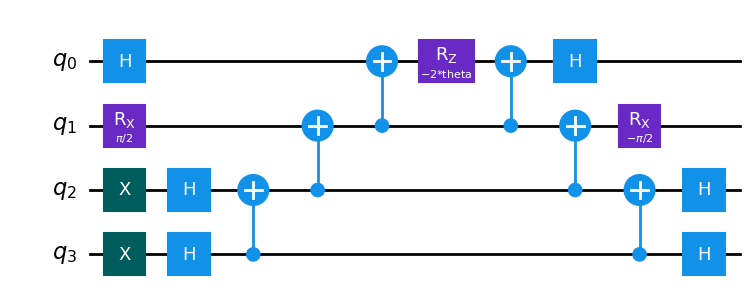

In [30]:
ansatz.draw(reverse_bits=False)

In [262]:
# cliche_1 = SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'], [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j])
parameters = 5

cliche_1_pauli = ['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ']
cliche_1_coeffs = [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j]
ansatz_1 = ansatz.copy()
ansatz_1.measure_all()
job_1 = sampler.run([(ansatz_1, parameters)], shots=shots1)
counts_1 = job_1.result()[0].data.meas.get_counts()
print("Counts:", counts_1)
total_counts = sum(counts_1.values())
probabilities = {state: count / total_counts for state, count in counts_1.items()}
# plot_histogram(counts_1)
plot_histogram(probabilities)

# Initialize the total expectation value
total_expectation_value = 0

def compute_contribution(pauli_string, state_bits):
    contribution = 1
    for i, pauli in enumerate(pauli_string):
        if pauli in ['X', 'Y', 'Z'] and state_bits[i] == 1:
            contribution *= -1
    return contribution

for pauli_string, coefficient in zip(cliche_1_pauli, cliche_1_coeffs):
    for state, prob in probabilities.items():
        state_bits = [int(bit) for bit in reversed(state)]  # Convert state to bitlist
        contribution = compute_contribution(pauli_string, state_bits)
        total_expectation_value += prob * contribution * coefficient

print("\nExpectation value Cliche 1:", total_expectation_value)

Counts: {'0011': 275, '1100': 25}



Expectation value Cliche 1: (-0.9851445199999997+0j)


In [27]:





# ansatz_1.measure_all()
# job_1 = sampler.run([(ansatz_1, parameters)], shots=shots1)
# counts_1 = job_1.result()[0].data.meas.get_counts()
# print("Counts:", counts_1)
# total_counts = sum(counts_1.values())
# probabilities = {state: count / total_counts for state, count in counts_1.items()}

# # Initialize the total expectation value
# total_expectation_value = += energy_1

def compute_contribution(pauli_string, state_bits):
    contribution = 1
    for i, pauli in enumerate(pauli_string):
        if pauli in ['X', 'Y', 'Z'] and state_bits[i] == 1:
            contribution *= -1
    return contribution

for pauli_string, coefficient in zip(cliche_1_pauli, cliche_1_coeffs):
    for state, prob in probabilities.items():
        state_bits = [int(bit) for bit in reversed(state)]  # Convert state to bitlist
        contribution = compute_contribution(pauli_string, state_bits)
        total_expectation_value += prob * contribution * coefficient

# print("\nExpectation value Cliche 1:", total_expectation_value)


def get_exp_vals(probabilities):
    exp_vals_sampler = 0
    for state, prob in probabilities.items():
        state_bits = [ int(bit) for bit in state]
        parity = state_bits[0] ^ state_bits[1] ^ state_bits[2] ^ state_bits[3]
        # print("State bits:", state_bits, "Parity:", parity)
        exp_vals_sampler += prob * (1 if parity == 0 else -1)
    return exp_vals_sampler


## CLICHE 2
cliche_2 = SparsePauliOp(['XXYY'], [-0.04530262+0.j])
ansatz_2 = ansatz.copy()
ansatz_2.h([0,1,2,3]) # Measurement basis
ansatz_2.sdg([2,3])
ansatz_2.measure_all()
job_2 = sampler.run([(ansatz_2, parameters)], shots=shots2)
counts_2 = job_2.result()[0].data.meas.get_counts()
total_shots_2 = sum(counts_2.values())
probabilities_2 = {state: count/total_shots_2 for state, count in counts_2.items()}
exp_vals_2 = get_exp_vals(probabilities_2)*cliche_2.coeffs[0]
print("Expectation value Cliche 2:", exp_vals_2)
total_expectation_value += exp_vals_2

# CLICHE 3
cliche_3 = SparsePauliOp(['XYYX'], [ 0.04530262+0.j])
ansatz_3 = ansatz.copy()
ansatz_3.h([0,1,2,3]) # Measurement basis
ansatz_3.sdg([1,2])
ansatz_3.measure_all()
job_3 = sampler.run([(ansatz_3, parameters)], shots=shots3)
counts_3 = job_3.result()[0].data.meas.get_counts()
total_shots_3 = sum(counts_3.values())
probabilities_3 = {state: count/total_shots_3 for state, count in counts_3.items()}
exp_vals_3 = get_exp_vals(probabilities_3)*cliche_3.coeffs[0]
print("Expectation value Cliche 3:", exp_vals_3)
total_expectation_value += exp_vals_3
print(ansatz_3)

# CLICHE 4
cliche_4 = SparsePauliOp(['YXXY'], [ 0.04530262+0.j])
ansatz_4 = ansatz.copy()
ansatz_4.h([0,1,2,3]) # Measurement basis
ansatz_4.sdg([0,3])
ansatz_4.measure_all()
job_4 = sampler.run([(ansatz_4, parameters)], shots=shots4)
counts_4 = job_4.result()[0].data.meas.get_counts()
total_shots_4 = sum(counts_4.values())
probabilities_4 = {state: count/total_shots_4 for state, count in counts_4.items()}
exp_vals_4 = get_exp_vals(probabilities_4)*cliche_4.coeffs[0]
print("Expectation value Cliche 4:", exp_vals_4)
total_expectation_value += exp_vals_4

# CLICHE 5
cliche_5 = SparsePauliOp(['YYXX'], [ -0.04530262+0.j])
ansatz_5 = ansatz.copy()
ansatz_5.h([0,1,2,3]) # Measurement basis
ansatz_5.sdg([0,1])
ansatz_5.measure_all()
job_5 = sampler.run([(ansatz_5, parameters)], shots=shots5)
counts_5 = job_5.result()[0].data.meas.get_counts()
total_shots_5 = sum(counts_5.values())
probabilities_5 = {state: count/total_shots_5 for state, count in counts_5.items()}
exp_vals_5 = get_exp_vals(probabilities_5)*cliche_5.coeffs[0]
print("Expectation value Cliche 5:", exp_vals_5)
total_expectation_value += exp_vals_5


print("Total Expectation Value:", total_expectation_value, "\n")

Expectation value Cliche 2: (-0.0015100873333333343+0j)
Expectation value Cliche 3: (-0.003926227066666664+0j)
           ┌───┐   ┌───┐                                                     »
   q_3: ───┤ X ├───┤ H ├──■───────────────────────────────────────────■──────»
           ├───┤   ├───┤┌─┴─┐                                       ┌─┴─┐    »
   q_2: ───┤ X ├───┤ H ├┤ X ├──■──────────────────────────────■─────┤ X ├────»
        ┌──┴───┴──┐└───┘└───┘┌─┴─┐                          ┌─┴─┐┌──┴───┴───┐»
   q_1: ┤ Rx(π/2) ├──────────┤ X ├──■────────────────────■──┤ X ├┤ Rx(-π/2) ├»
        └──┬───┬──┘          └───┘┌─┴─┐┌──────────────┐┌─┴─┐├───┤└──┬───┬───┘»
   q_0: ───┤ H ├──────────────────┤ X ├┤ Rz(-2*theta) ├┤ X ├┤ H ├───┤ H ├────»
           └───┘                  └───┘└──────────────┘└───┘└───┘   └───┘    »
meas: 4/═════════════════════════════════════════════════════════════════════»
                                                                             »
«        ┌───┐ ┌───┐

[[ 7.47883634e-02]
 [-1.08726288e-04]
 [ 8.15447160e-05]
 [-1.35907860e-04]
 [-6.79539300e-04]]
Mean: 0.014789146933199989


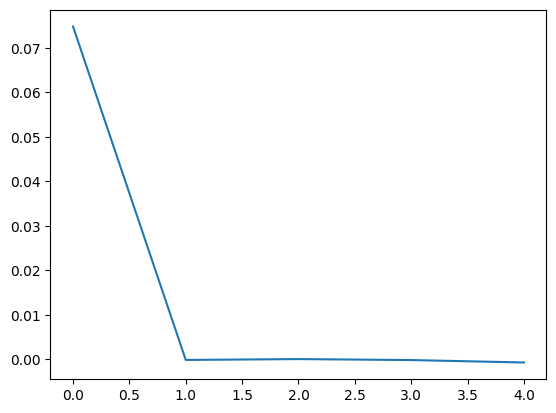

In [116]:
job = estimator.run([(qc, obsv_list, angles, 0.01)])
exp_vals = job.result()[0].data.evs
print(exp_vals)
print("Mean:", np.mean(exp_vals))
plt.plot(exp_vals)

### Sampler

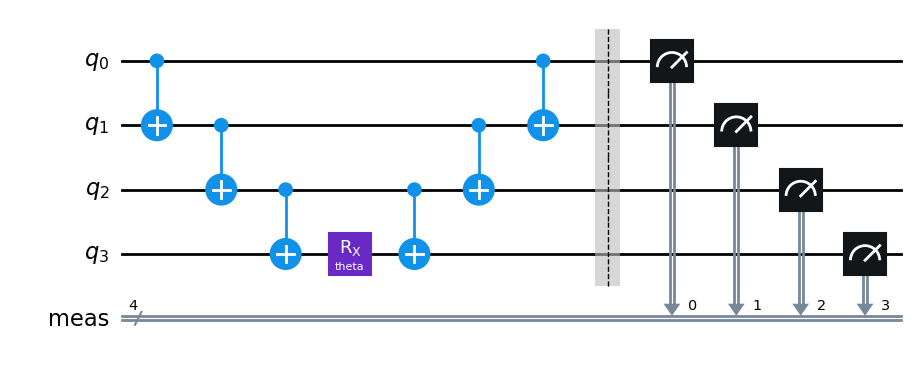

In [117]:
theta = Parameter('theta')

qc = QuantumCircuit(4)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.rx(theta, 3)
qc.cx(2,3)
qc.cx(1,2)
qc.cx(0,1)

# qc.measure(qr, cr)
qc.measure_all()
qc.draw(reverse_bits=False)

{'1000': 536, '0000': 488}


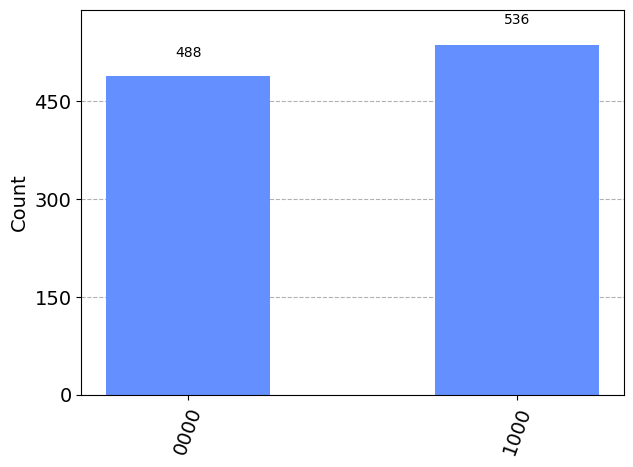

In [118]:
sampler = SamplerV2(backend=AerSimulator())
job = sampler.run([(qc, angles)])
counts = job.result()[0].data.meas.get_counts()
print(counts)
plot_histogram(counts)

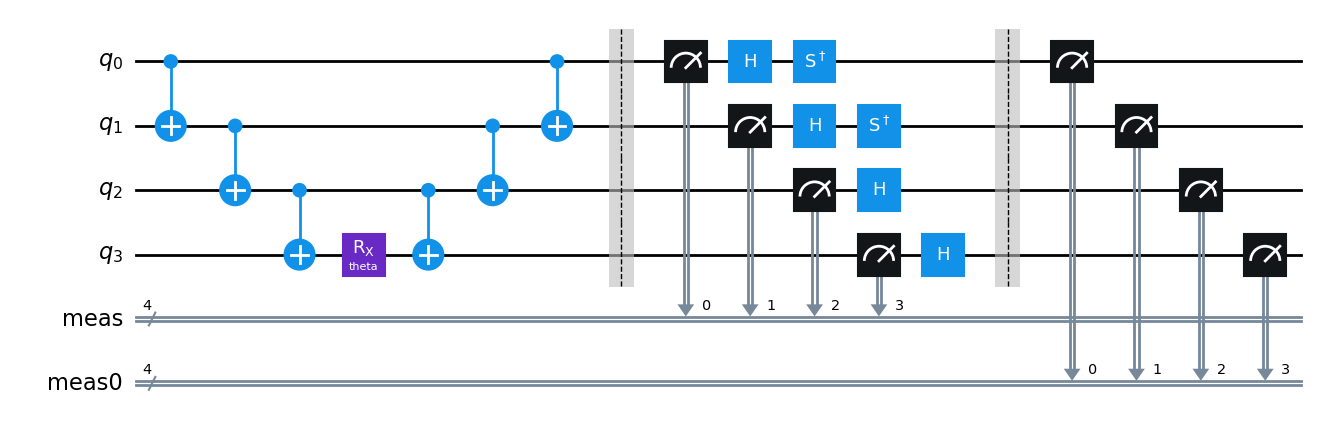

In [119]:
## YYXX Observables
theta = Parameter('theta')

qc_sampler = qc.copy()

qc_sampler.h(0)
qc_sampler.sdg(0)
qc_sampler.h(1)
qc_sampler.sdg(1)
qc_sampler.h(2)
qc_sampler.h(3)

# qc.measure(qr, cr)
qc_sampler.measure_all()
qc_sampler.draw(reverse_bits=False)

In [ ]:
            # CLICHE 5
            cliche_5 = SparsePauliOp(['XYYX'], [ 0.04530262+0.j])
            ansatz_5 = ansatz.copy()
            ansatz_5.h([0,1,2,3]) # Measurement basis
            ansatz_5.sdg([2,3])
            ansatz_5.measure_all()
            job_5 = sampler.run([(ansatz_5, parameters)], shots=shots2)
            counts_5 = job_5.result()[0].data.meas.get_counts()
            total_shots_5 = sum(counts_5.values())
            probabilities_5 = {state: count/total_shots_5 for state, count in counts_5.items()}
            exp_vals_5 = get_exp_vals(probabilities_5)*cliche_5.coeffs[0]
            print("Expectation value Cliche 5:", exp_vals_5)
            total_expectation_value += exp_vals_5

In [120]:
sampler = SamplerV2(backend=AerSimulator())
job = sampler.run([(qc_sampler, angles)], shots=10000)
counts = job.result()[0].data.meas.get_counts()
print("Counts:", counts)
plot_histogram(counts)



total_shots = sum(counts.values())
print("Total Shots:", total_shots)
probabilities = {state: count/total_shots for state, count in counts.items()}
print("probabilities:", probabilities)

# Measure the Expectation Value
exp_vals_sampler = 0

for state, prob in probabilities.items():
    state_bits = [ int(bit) for bit in state]
    parity = state_bits[0] ^ state_bits[1] ^ state_bits[2] ^ state_bits[3]
    print("State bits:", state_bits, "Parity:", parity)
    exp_vals_sampler += prob * (1 if parity == 0 else -1)

print(exp_vals_sampler)

Counts: {'1000': 5014, '0000': 4986}
Total Shots: 10000
probabilities: {'1000': 0.5014, '0000': 0.4986}
State bits: [1, 0, 0, 0] Parity: 1
State bits: [0, 0, 0, 0] Parity: 0
-0.002799999999999969


### Comparison

[[ 0.09371334]
 [ 0.00049833]
 [-0.00028088]
 [-0.00017215]
 [ 0.00026276]]
Mean: 0.018804279778400004
Counts: {'0000': 4994, '1000': 5006}
Total Shots: 10000
probabilities: {'0000': 0.4994, '1000': 0.5006}
State bits: [0, 0, 0, 0] Parity: 0
State bits: [1, 0, 0, 0] Parity: 1
Using Estimator: -0.000172149956
Using Sampler: 5.436000000000156e-05
DIfference: -0.00022650995600000156


(-0.01, 0.01)

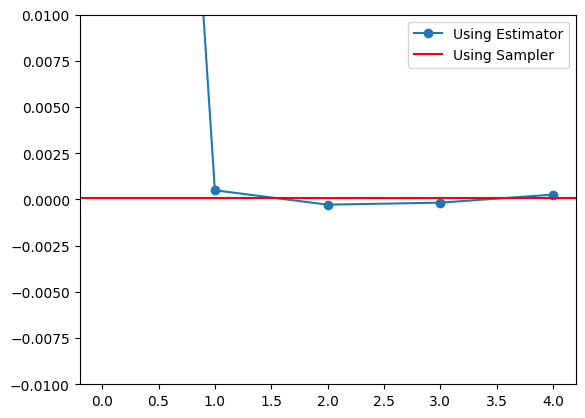

In [144]:
job = estimator.run([(qc, obsv_list, angles, 0.01)])
exp_vals = job.result()[0].data.evs
print(exp_vals)
print("Mean:", np.mean(exp_vals))

sampler = SamplerV2(backend=AerSimulator())
job = sampler.run([(qc_sampler, angles)], shots=10000)
counts = job.result()[0].data.meas.get_counts()
print("Counts:", counts)
plot_histogram(counts)



total_shots = sum(counts.values())
print("Total Shots:", total_shots)
probabilities = {state: count/total_shots for state, count in counts.items()}
print("probabilities:", probabilities)

# Measure the Expectation Value
exp_vals_sampler = 0

for state, prob in probabilities.items():
    state_bits = [ int(bit) for bit in state]
    parity = state_bits[0] ^ state_bits[1] ^ state_bits[2] ^ state_bits[3]
    print("State bits:", state_bits, "Parity:", parity)
    exp_vals_sampler += prob * (1 if parity == 0 else -1)

print("Using Estimator:",exp_vals[3][0])
print("Using Sampler:", exp_vals_sampler*-0.04530)
print("DIfference:", exp_vals[3][0]-exp_vals_sampler*-0.04530)

plt.plot(exp_vals, label='Using Estimator', marker='o')
plt.axhline(y=exp_vals_sampler*-0.0453, color='r', label='Using Sampler')
plt.legend()
plt.ylim(-0.01,0.01)
# plt.plot(4,exp_vals_sampler*-0.04530)

In [153]:
a = SparsePauliOp(['XXYY'], [-0.04530262+0.j])
print(a)
print(type(a))
b = 2*a.coeffs[0]
print(a.coeffs[0])
print(type(b))
print(2)

SparsePauliOp(['XXYY'],
              coeffs=[-0.04530262+0.j])
<class 'qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp'>
(-0.04530262+0j)
<class 'numpy.complex128'>
2


In [58]:
print(obsv_list)
print(exp_vals)
print(exp_vals_sampler*-0.04530)

[[SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j,
 -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j,
  0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j])], [SparsePauliOp(['XXYY'],
              coeffs=[-0.04530262+0.j])], [SparsePauliOp(['XYYX'],
              coeffs=[0.04530262+0.j])], [SparsePauliOp(['YXXY'],
              coeffs=[0.04530262+0.j])], [SparsePauliOp(['YYXX'],
              coeffs=[-0.04530262+0.j])]]
[[ 0.08318554]
 [-0.00030806]
 [ 0.00061612]
 [-0.0003443 ]
 [ 0.00059799]]
3.623999999999946e-05
